In [1]:
#importing packages
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
# from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

No. of car images: 8792
No. of non-vehicle images: 8968


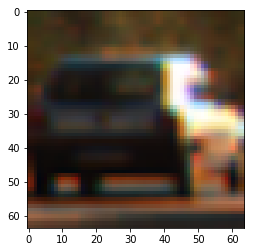

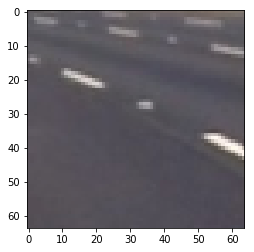

In [2]:
#Read in car image file name
cars=glob.glob('Data/vehicles/vehicles/*/*.png')
# cars=glob.glob('Data/vehicles/vehicles/KITTI_extracted/*.png')

print('No. of car images:',len(cars))

#Read in non-car image file names
not_cars=glob.glob('Data/non-vehicles/non-vehicles/*/*.png')
# not_cars=glob.glob('Data/non-vehicles/non-vehicles/Extras/*.png')

print('No. of non-vehicle images:',len(not_cars))

#Display random images from the dataset
rand_index_car = np.random.randint(0, len(cars))
rand_index_not_car = np.random.randint(0, len(not_cars))

car_img=mpimg.imread(cars[rand_index_car])
not_car_img=mpimg.imread(not_cars[rand_index_not_car])

plt.imshow(car_img)
plt.show()
plt.imshow(not_car_img)
plt.show()

In [3]:
# Function to return HOG features and visualization (if vis==True)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Return with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise Return with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

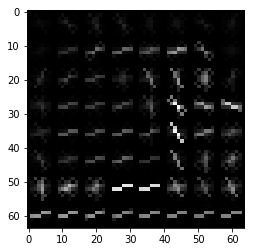

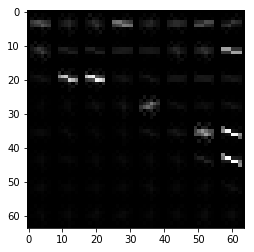

In [4]:
#Testing the get_hog_features() function
feature_image = cv2.cvtColor(car_img, cv2.COLOR_BGR2YUV)
feat, hog_image = get_hog_features(feature_image[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
plt.imshow(hog_image,cmap='gray')
plt.show()

feature_image = cv2.cvtColor(not_car_img, cv2.COLOR_BGR2YUV)
feat, hog_image = get_hog_features(feature_image[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
plt.imshow(hog_image,cmap='gray')
plt.show()

In [5]:
# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector by resizing it and flattening it
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Computing the histogram of the color channels separately
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def extract_features(imgs, cspace, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel):
    
    # List to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)   
            
        # Get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Get color space histogram
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Get the HOG fetures
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the feature vectors to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

In [7]:
#Defining the parameters
spatial = 32
histbin = 64
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0   # Can be 0, 1, 2, or "ALL"
hist_range=(0, 256)

#Extract features fro the car and non-car images
car_features = extract_features(cars, colorspace, (spatial, spatial), histbin, (0, 256), orient, pix_per_cell, cell_per_block, hog_channel)
not_car_features = extract_features(not_cars, colorspace, (spatial, spatial), histbin, (0, 256), orient, pix_per_cell, cell_per_block, hog_channel )

In [8]:
#Displaying the feature vector length
print(len(car_features[0]))
print(len(not_car_features[0]))

5028
5028


In [9]:
# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [10]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [79]:
# Use a SVC 
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC(kernel='rbf',C=10)
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)
# best_clf = clf.best_estimator_

# print(best_clf)

# pred = best_clf.predict(X_test)

#Training the classifier with the training data
svc.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [80]:
#Printing the accuracy of the classifier
pred=svc.predict(X_test)
print('Test Accuracy:',accuracy_score(pred,y_test))

Test Accuracy: 0.9884572072072072


In [ ]:
# save the classifier

filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [11]:
# load the model from disk

filename = 'finalized_model.sav'
svc = pickle.load(open(filename, 'rb'))

# #Verifying the accuracy
# res=accuracy_score(pred,y_test)
# print(res)

In [12]:
# Function that extracts features using hog sub-sampling and make predictions
def find_cars(img, cspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #Copy of the image
    draw_img = np.copy(img)
    #Converting input to 0 to 1, as training png images are loaded using matplotlib and frames are loaded as 0 to 255
    img = img.astype(np.float32)/255
    
    #Restrict the search space
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    #Convert to colorspace given as the parameter to this function
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    else: ctrans_tosearch = np.copy(image)  
    
    #Scale the image to adjust cells per window
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #Take the color channel to be processed
    ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # Define window size and cells and blocks per window
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list=[]
    
    #Go through each window
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            combined_feature=np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(combined_feature)    
            test_prediction = svc.predict(test_features)
            
            #If predicted as car, draw the box in image
            if test_prediction == 1:
                xbox_left = np.int(xstart + xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    #Return image with windows where car was identified and the boxes           
    return draw_img,box_list

In [13]:
#Function to add heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

#Function to apply threshold to the heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#Function to draw a single box in the image for the cars identified from the heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [18]:
#Function pipeline that takes in image and returns image with bounding boxes aroun the cars in the image
def car_find_pipeline(image):
    global heat_stacked
    #Remove the oldest heatmap from the stacked heatmaps
    heat_stacked=heat_stacked[:,:,1:]
    
    #Define parameters
    xstart = 400
    xtop = image.shape[1]
    ystart = 380
    ystop = 656
    scale = 1.4
    spatial_size = 32
    histbin = 64
    cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hist_range=(0, 256)

    #Call find_cars() to get the image with windows around cars and the boxes
    out_img,box_list = find_cars(image, cspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size,spatial_size), histbin)
    
    #Define new heatmap with zeros filled in it
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    #Stack the new heat map for current image to the heat_stacked
#     heat_stacked=np.dstack((heat_stacked,heat))
    
    #Taking the sum of the pixel values through depth
#     heat=np.sum(heat_stacked,axis=2)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)   
   
    # Find final boxes from heatmap using label function
    #heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    
    heat_ones=np.zeros_like(heat)
    heat_ones[heat>=1]=1
    heat_stacked=np.dstack((heat_stacked,heat))
    heat=np.sum(heat_stacked,axis=2)
    heat = apply_threshold(heat,5)
    
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

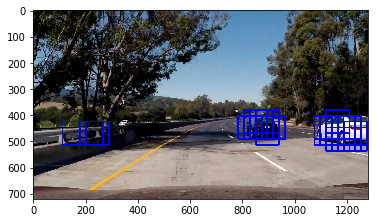

In [15]:
#Testing the find_cars() function
#Reading the image
img=mpimg.imread('test_images/test1.jpg')

#Defining the parameters
ystart = 380
ystop = 656
scale = 1.4
spatial_size = 32
histbin = 64
orient = 9
pix_per_cell = 8
cell_per_block = 2
hist_range=(0, 256)
cspace= 'YUV'
xstart =0
xstop = img.shape[1]

#Reading the image
img=mpimg.imread('test_images/test5.jpg')

out_img,box_list = find_cars(img, cspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block, (spatial_size,spatial_size), histbin)

plt.imshow(out_img)

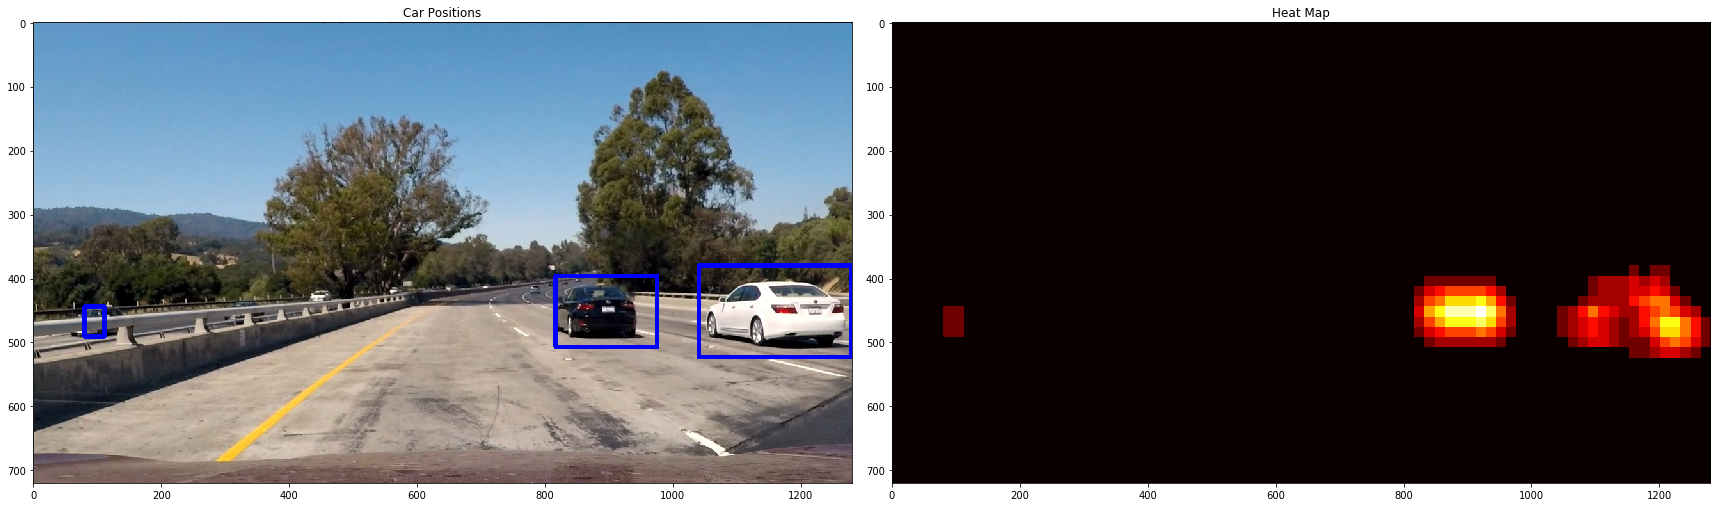

In [25]:
#Testing the heatmap functions

heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [19]:
#Define the output video location
project_out = 'output_videos/project_video_out_2.mp4'

#Input video
clip1 = VideoFileClip("project_video.mp4").subclip(20,25)

#Getting a frame from the video
in_img= clip1.get_frame(0)

#Initialise heatmap and heat_stacked. heat_stacked will store last 5 frames heat maps
heat = np.zeros_like(in_img[:,:,0]).astype(np.float)
heat_stacked = np.dstack((heat,heat,heat,heat,heat))

#Process frames from the video and save it
white_clip = clip1.fl_image(car_find_pipeline)
%time white_clip.write_videofile(project_out, audio=False)

OSError: [WinError 6] The handle is invalid